# Portfolio Project: COVID-19 detection using Chest X-rays

**Task:** Detect if the Chest X-ray represents - COVID-19, Viral Pneumonia, or Healthy/Normal.

**Dataset:**

  * **Name:** Covid-19 Image Dataset
  * **Website:** *Kaggle*
  * **Where to find data:** https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
  * **Acknowledgements:** The University of Montreal for releasing the images.



In [ ]:
import sklearn
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras import layers

In [ ]:
# Open zipfile
import zipfile

with zipfile.ZipFile('archive (4).zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# Get path to the train and test image directories
train_path = 'Covid19-dataset/train'
test_path = 'Covid19-dataset/test'

In [ ]:
# We will use image_dataset_from_directory because it returns data in tf.data.Dataset format

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                                 image_size=(224, 224),
                                                                 batch_size=None,
                                                                 label_mode='categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                                image_size=(224, 224),
                                                                batch_size=None,
                                                                label_mode='categorical')

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


In [ ]:
train_data

<_ShuffleDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
len(train_data), len(test_data)

(251, 66)

## Visualize data

In [ ]:
# Check first example, we are interested in the shape, dtype and min and max value of the images
train_sample = train_data.take(1)

for image, label in train_sample:
  print(f'Image: {image.shape, image.dtype}')
  print(f'Label: {label.shape, label.dtype}')
  print(tf.reduce_min(image), tf.reduce_max(image))

Image: (TensorShape([224, 224, 3]), tf.float32)
Label: (TensorShape([3]), tf.float32)
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(255.0, shape=(), dtype=float32)


**Note:** Notice that our labels are OneHotEncoded and have shape of 3

example:
```
 [ 0, 0, 1 ] -> 'Viral Pneumonia',
 [ 1, 0, 0 ] -> 'Covid'
 [ 0, 1, 0 ] -> 'Normal'
```


In [ ]:
# get class names
class_names = train_data.class_names

class_names

['Covid', 'Normal', 'Viral Pneumonia']

In [ ]:
# We will unbatch our tf.data.Dataset, so that we could randomly visualize our images
train_images_list = []
train_labels_list = []

for image, label in train_data:
  train_images_list.append(image)
  train_labels_list.append(label)

len(train_images_list), len(train_labels_list)

(251, 251)

In [ ]:
def plot_Covid_images(images, labels, num, class_names):
  fig = plt.figure()
  for i in range(num):
    cnum = int(np.random.randint(0, len(images), 1))
    name = class_names[np.argmax(labels[cnum])]
    ax = fig.add_subplot(3, 3, i + 1)

    image = images[cnum] / 255.

    ax.imshow(image)
    ax.set_title(f'{name}', fontsize=6)
    ax.axis('off');

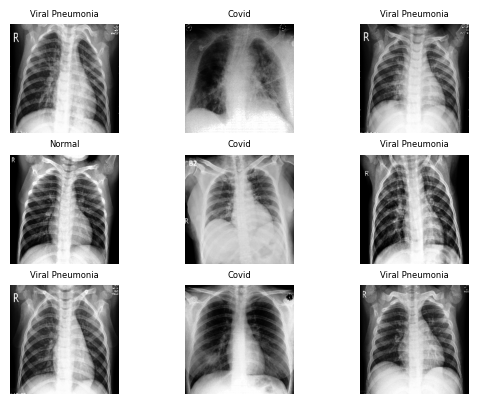

In [ ]:
plot_Covid_images(train_images_list, train_labels_list, 9, class_names)

## Preprocess data

In [ ]:
# We used image_dataset_from_directory to get the data, so we don't need to reshape or change dtype of the data

def preprocess_function_scale(image, label, img_size=224):
  # image = tf.image.resize(image, size=(img_size, img_size))

  # image = tf.cast(image, dtype=tf.float32)

  image = image / 255.

  return image, label

In [ ]:
# Prepare datasets - (map preprocessing function, shuffle, batch, prefetch)

# train data
train_data_prep = train_data.map(map_func=preprocess_function_scale, num_parallel_calls=tf.data.AUTOTUNE)

train_data_prep = train_data_prep.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# test_data
test_data_prep = test_data.map(map_func=preprocess_function_scale, num_parallel_calls=tf.data.AUTOTUNE)

test_data_prep = test_data_prep.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data_prep, test_data_prep

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>)

## Build Models

### Simple CNN model

In [ ]:
inputs = layers.Input(shape=(224, 224, 3), dtype=tf.float32)

x = layers.Conv2D(32, 3, padding='same')(inputs)
x = layers.Conv2D(32, 3, padding='same')(x)
x = layers.Conv2D(32, 3, padding='same')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same')(x)
x = layers.Conv2D(64, 3, padding='same')(x)
x = layers.Conv2D(64, 3, padding='same')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.MaxPool2D()(x)

# x = layers.Conv2D(256, 3, padding='same')(x)
# x = layers.Conv2D(256, 3, padding='same')(x)
# x = layers.Conv2D(256, 3, padding='same')(x)
# x = layers.MaxPool2D()(x)

x = layers.GlobalMaxPool2D()(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs, name='model_1_CNN')

In [ ]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(), # We have OneHotEncode labels, so we need to use CategoricalCrossentropy
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model_1_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                       

In [ ]:
history_1 = model_1.fit(train_data_prep,
                        epochs=15,
                        validation_data=test_data_prep)

Epoch 1/15
8/8 [==============================] - 26s 725ms/step - loss: 1.3861 - accuracy: 0.3825 - val_loss: 1.0799 - val_accuracy: 0.4091
Epoch 2/15
8/8 [==============================] - 6s 248ms/step - loss: 1.0105 - accuracy: 0.4781 - val_loss: 0.9856 - val_accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 5s 250ms/step - loss: 0.8866 - accuracy: 0.5817 - val_loss: 0.9111 - val_accuracy: 0.5758
Epoch 4/15
8/8 [==============================] - 6s 249ms/step - loss: 0.7488 - accuracy: 0.6972 - val_loss: 0.8290 - val_accuracy: 0.5606
Epoch 5/15
8/8 [==============================] - 6s 248ms/step - loss: 0.7187 - accuracy: 0.6733 - val_loss: 0.8327 - val_accuracy: 0.6061
Epoch 6/15
8/8 [==============================] - 5s 262ms/step - loss: 0.5627 - accuracy: 0.7649 - val_loss: 0.6237 - val_accuracy: 0.6667
Epoch 7/15
8/8 [==============================] - 6s 268ms/step - loss: 0.4210 - accuracy: 0.8645 - val_loss: 0.5893 - val_accuracy: 0.7121
Epoch 8/15
8/8 [===

In [ ]:
model_1_pred_acc = model_1.evaluate(test_data_prep)

3/3 [==============================] - 1s 46ms/step - loss: 0.7650 - accuracy: 0.7273


In [ ]:
def plot_loss_acc(history):
  pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

  pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

  plt.show()

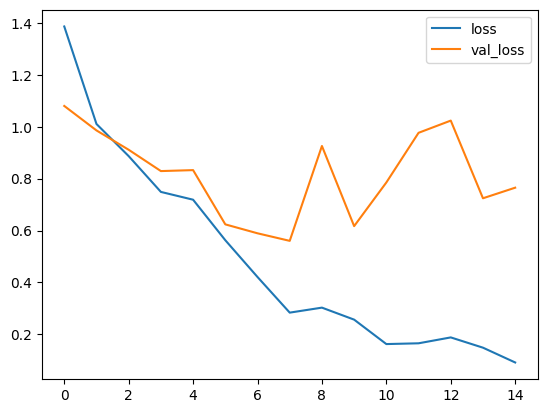

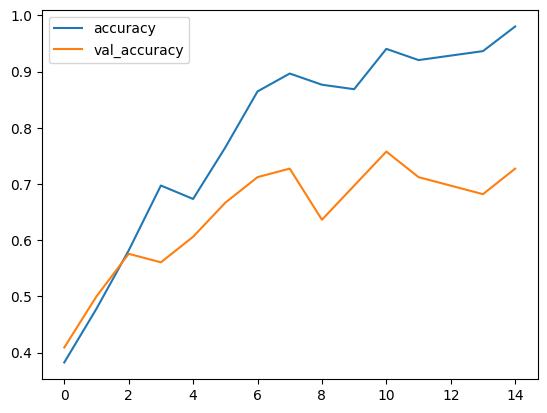

In [ ]:
plot_loss_acc(history_1)

### Prepare data for Transfer Learning model

In [ ]:
# Prepare data for transfer learning model

# train data
train_data_transfer = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# test_data
test_data_transfer = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data_transfer, test_data_transfer

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>)

### EffNet model

In [ ]:
base_model_eff = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_eff.trainable = False

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
inputs = layers.Input(shape=(224, 224, 3), dtype=tf.float32)

x = base_model_eff(inputs, training=False)

x = layers.GlobalMaxPool2D()(x)

outputs = layers.Dense(units=len(class_names), activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs, name='model_2_EffNet')

In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_EffNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
history_2 = model_2.fit(train_data_transfer,
                        epochs=15,
                        validation_data=test_data_transfer)

Epoch 1/15
8/8 [==============================] - 15s 497ms/step - loss: 1.5747 - accuracy: 0.3785 - val_loss: 1.0089 - val_accuracy: 0.5606
Epoch 2/15
8/8 [==============================] - 7s 187ms/step - loss: 0.5844 - accuracy: 0.7450 - val_loss: 0.7113 - val_accuracy: 0.6818
Epoch 3/15
8/8 [==============================] - 6s 220ms/step - loss: 0.3110 - accuracy: 0.9124 - val_loss: 0.5613 - val_accuracy: 0.7576
Epoch 4/15
8/8 [==============================] - 6s 209ms/step - loss: 0.2355 - accuracy: 0.9163 - val_loss: 0.5243 - val_accuracy: 0.7576
Epoch 5/15
8/8 [==============================] - 6s 159ms/step - loss: 0.1884 - accuracy: 0.9323 - val_loss: 0.4592 - val_accuracy: 0.7879
Epoch 6/15
8/8 [==============================] - 7s 454ms/step - loss: 0.1616 - accuracy: 0.9442 - val_loss: 0.4348 - val_accuracy: 0.7879
Epoch 7/15
8/8 [==============================] - 4s 144ms/step - loss: 0.1452 - accuracy: 0.9562 - val_loss: 0.4130 - val_accuracy: 0.7879
Epoch 8/15
8/8 [===

In [ ]:
model_2_pred_acc = model_2.evaluate(test_data_transfer)

3/3 [==============================] - 1s 49ms/step - loss: 0.3062 - accuracy: 0.8788


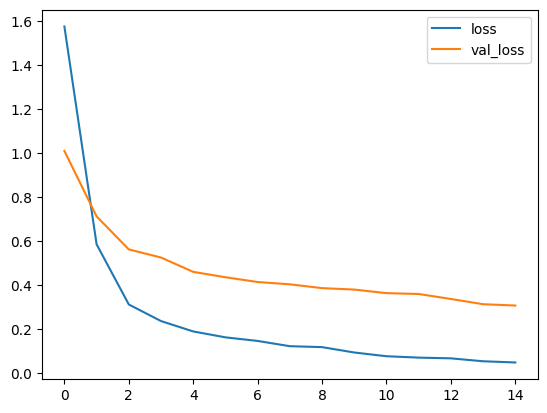

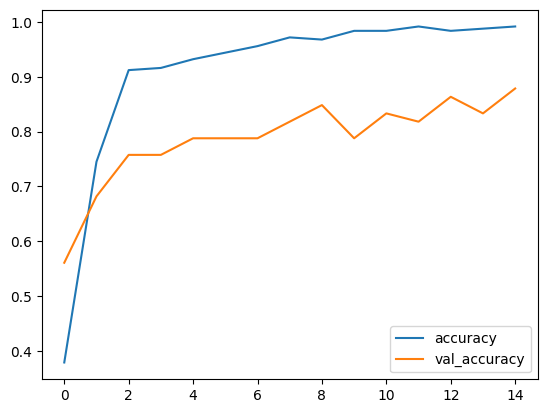

In [ ]:
plot_loss_acc(history_2)

## Add data augmentation to our models

Our model overfits on the training data, we should add regularization technique (In this example we will use data augmentation but we can also experiment with `Dropout` if we want)

In [ ]:
data_augmentation_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomHeight(0.6),
    layers.experimental.preprocessing.RandomWidth(0.6),
    layers.experimental.preprocessing.RandomZoom(0.6)
])

### Effnet feature extractor + data augmentation

We are using effnet model because data augmentation increases training time by a lot, so it is easier and faster to train feature extractor model that has only one layer to train.

In [ ]:
base_model_eff = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_eff.trainable = False

In [ ]:
inputs = layers.Input(shape=(224, 224, 3), dtype=tf.float32)

x = data_augmentation_layer(inputs)

x = base_model_eff(x, training=False)

x = layers.GlobalMaxPool2D()(x)

outputs = layers.Dense(units=len(class_names), activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3_EffNet_aug')

In [ ]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "model_3_EffNet_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d_5 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_4 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
__________________________________

In [ ]:
history_3 = model_3.fit(train_data_transfer,
                        epochs=10, # we will train for 10 epochs and then fine-tune for 10 more
                        validation_data=test_data_transfer)

Epoch 1/10
8/8 [==============================] - 16s 649ms/step - loss: 2.0229 - accuracy: 0.4303 - val_loss: 1.4666 - val_accuracy: 0.4394
Epoch 2/10
8/8 [==============================] - 8s 433ms/step - loss: 1.7164 - accuracy: 0.4382 - val_loss: 1.1111 - val_accuracy: 0.5152
Epoch 3/10
8/8 [==============================] - 8s 542ms/step - loss: 1.1890 - accuracy: 0.5259 - val_loss: 0.7724 - val_accuracy: 0.6515
Epoch 4/10
8/8 [==============================] - 6s 406ms/step - loss: 0.8622 - accuracy: 0.6255 - val_loss: 0.9791 - val_accuracy: 0.6212
Epoch 5/10
8/8 [==============================] - 7s 429ms/step - loss: 0.9182 - accuracy: 0.6534 - val_loss: 0.7528 - val_accuracy: 0.6667
Epoch 6/10
8/8 [==============================] - 6s 397ms/step - loss: 0.7518 - accuracy: 0.7171 - val_loss: 0.8324 - val_accuracy: 0.6667
Epoch 7/10
8/8 [==============================] - 6s 421ms/step - loss: 0.7863 - accuracy: 0.6494 - val_loss: 0.7049 - val_accuracy: 0.7121
Epoch 8/10
8/8 [===

### Effnet fine-tune + data augmentation

In [ ]:
# Check what layers does our model have and are they trainable ?
for layer in model_3.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7d914823fe80> True
<keras.engine.sequential.Sequential object at 0x7d9148674af0> True
<keras.engine.functional.Functional object at 0x7d91482693c0> False
<keras.layers.pooling.global_max_pooling2d.GlobalMaxPooling2D object at 0x7d916f1ffcd0> True
<keras.layers.core.dense.Dense object at 0x7d914811b940> True


In [ ]:
# What layers are in our base model and are they trainable ?
for i, layer in enumerate(model_3.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_10 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fal

In [ ]:
# We should unfreeze only the last 10 layers, so that our model didn't take to long to train
base_model_eff.trainable = True

for layer in base_model_eff.layers[:-50]:
  layer.trainable = False

# Recompile (we have to recompile our model each time we are making changes to our model)
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # because we are fine-tuning our model we would like to lower our learning rate by 10x
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [ ]:
# Check what layers are tunable (trainable)
for i, layer in enumerate(model_3.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_10 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fal

In [ ]:
# Count how many trainable layers our model has
print(len(model_3.layers[2].trainable_variables))

45


In [ ]:
save_model_path = 'saved_models/best_model_weights'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path,
                                                               save_best_only=True,
                                                               save_weights_only=True)

In [ ]:
history_3_fine_tune = model_3.fit(train_data_transfer,
                                  epochs=30,
                                  validation_data=test_data_transfer,
                                  callbacks=[model_checkpoint_callback],
                                  initial_epoch=history_3.epoch[-1]) # start training from the last extractor epoch

Epoch 10/30
8/8 [==============================] - 24s 757ms/step - loss: 0.6165 - accuracy: 0.7490 - val_loss: 0.9909 - val_accuracy: 0.6818
Epoch 11/30
8/8 [==============================] - 7s 517ms/step - loss: 0.6394 - accuracy: 0.7171 - val_loss: 0.5080 - val_accuracy: 0.8182
Epoch 12/30
8/8 [==============================] - 7s 519ms/step - loss: 0.4540 - accuracy: 0.8048 - val_loss: 0.6470 - val_accuracy: 0.7273
Epoch 13/30
8/8 [==============================] - 9s 564ms/step - loss: 0.5163 - accuracy: 0.8127 - val_loss: 0.3980 - val_accuracy: 0.8636
Epoch 14/30
8/8 [==============================] - 7s 509ms/step - loss: 0.4016 - accuracy: 0.8725 - val_loss: 0.4249 - val_accuracy: 0.8182
Epoch 15/30
8/8 [==============================] - 7s 553ms/step - loss: 0.3740 - accuracy: 0.8685 - val_loss: 0.3172 - val_accuracy: 0.8788
Epoch 16/30
8/8 [==============================] - 9s 578ms/step - loss: 0.3264 - accuracy: 0.8406 - val_loss: 0.2697 - val_accuracy: 0.9091
Epoch 17/30


In [ ]:
# Without loading Checkpoint weights
model_3.evaluate(test_data_transfer)

3/3 [==============================] - 1s 49ms/step - loss: 0.1893 - accuracy: 0.9091


[0.18932798504829407, 0.9090909361839294]

In [ ]:
model_3.load_weights(save_model_path)

In [ ]:
# With saved Checkpoint weights
model_3.evaluate(test_data_transfer)

3/3 [==============================] - 1s 50ms/step - loss: 0.1549 - accuracy: 0.9394


[0.15487009286880493, 0.939393937587738]

## Test our best Models

In [ ]:
unbatch_test_images = []
unbatch_test_labels = []

for image, label in test_data_transfer.unbatch():
  unbatch_test_images.append(image)
  unbatch_test_labels.append(label)

len(unbatch_test_images), len(unbatch_test_labels)

(66, 66)

In [ ]:
# Create a function to make and plot prediction
def pred_plot_image(model, images, labels, class_names):

  num = np.random.randint(0, len(images))
  pred_probs = model.predict(tf.expand_dims(images[num], axis=0))
  pred_label = int(tf.argmax(pred_probs, axis=1))
  image = images[num] /255.

  plt.figure()
  plt.imshow(image)
  plt.title(f'True Label: {class_names[np.argmax(labels[num])]} - {np.argmax(labels[num])}\nPred Label: {class_names[pred_label]} - {pred_label}')
  plt.axis('off')

1/1 [==============================] - 0s 37ms/step


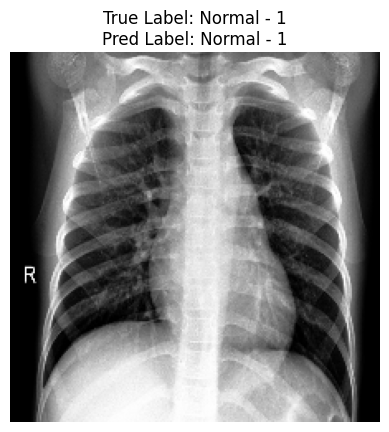

In [ ]:
pred_plot_image(model_3, unbatch_test_images, unbatch_test_labels, class_names)